In [3]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem

2023-03-11 21:59:19.183131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read images
AIA193_2016 = sunpy.map.Map("data/aia_193A/2016-01*.fits")
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))


# Normalize images
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg


# Discretize images to detect faulty data
AIA193_2016_bytes = np.round(AIA193_2016_mnorm*255).astype(np.uint8)


# Calculate histograms
nbins = 10
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(0,256,nbins))[0] for i in AIA193_2016_bytes])


# Cluster histograms
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(hist_vectors/hist_vectors.max())

class1 = AIA193_2016_bytes[kmeans.labels_ == kmeans.labels_[0], :, :]
class2 = AIA193_2016_bytes[kmeans.labels_ != kmeans.labels_[0], :, :]

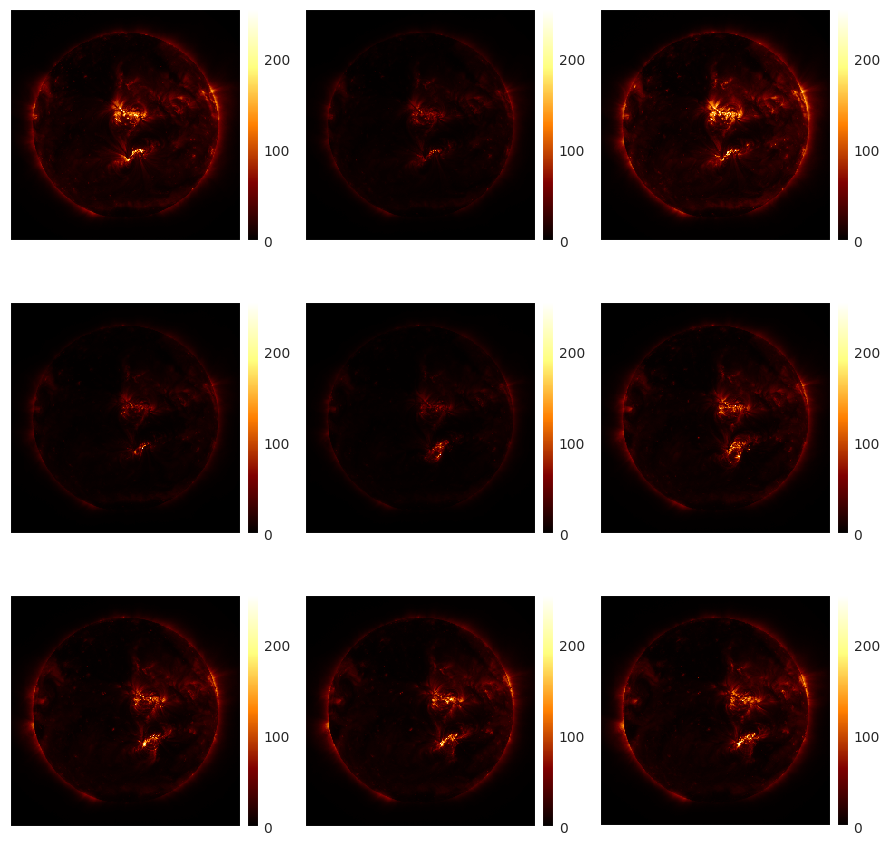

In [3]:
isns.ImageGrid([i for i in class1[:9]], cmap="afmhot") # class2 is (probably) noise 

In [4]:
clean_input = AIA193_2016_mnorm[kmeans.labels_ == kmeans.labels_[0], :, :]
clean_input_train, clean_input_test = train_test_split(clean_input, test_size=0.25)

In [19]:
pd.DataFrame({"Latent":k_search, "MSE":mse_values}).to_csv("knee_AE1.csv", index=False)

In [16]:
latent_size = 64
n_epochs = 200
batch_size = 128

k_search = np.concatenate([np.arange(1, 16, 2), np.arange(16, 64, 4), np.arange(64, 256, 16), np.arange(256, 1024, 32), [1024]])

for i in range(1, 15):
    mse_values = []
    for k in k_search:
        print(f"\nStarting training for k={k}")
        autoencoder, _, _ = aem.gen_autoenc_model(k, optim="adam", loss="mse", verbose=False)
        autoencoder.fit(clean_input_train.reshape([-1, 256,256,1]), clean_input_train.reshape([-1, 256,256,1]), validation_split=0.2, epochs=n_epochs, batch_size=batch_size, verbose=False)

        print(f"Finished training for k={k}")

        mse_value = autoencoder.evaluate(clean_input_test.reshape([-1, 256,256,1]), clean_input_test.reshape([-1, 256,256,1]))[0]
        mse_value_array = np.array(mse_value)
        mse_values.append(mse_value)

        del autoencoder
        del mse_value

    pd.DataFrame({"Latent":k_search, "MSE":mse_values}).to_csv(f"knee_AE{i+1}.csv", index=False)


Starting training for k=1
Finished training for k=1
2/2 [==============================] - 0s 7ms/step - loss: 0.0014 - mae: 0.0182

Starting training for k=2
Finished training for k=2
2/2 [==============================] - 0s 6ms/step - loss: 0.0013 - mae: 0.0174

Starting training for k=3
Finished training for k=3
2/2 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0164

Starting training for k=4
Finished training for k=4
2/2 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0148

Starting training for k=5
Finished training for k=5
2/2 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0148

Starting training for k=6
Finished training for k=6
2/2 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0149

Starting training for k=7
Finished training for k=7
2/2 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0178

Starting training for k=8
Finished training for k=8
2/2 [===========

KeyboardInterrupt: 

In [1]:
plt.plot(mse_values)

NameError: name 'plt' is not defined

In [28]:
collected_data_files = [
    "knee_AE0.csv",
    "knee_AE1.csv",
    "knee_AE2.csv",
    "knee_AE3.csv",
    "knee_AE4.csv"
]


collected_data = pd.read_csv("knee_AE0.csv")
collected_data["MSE"] = 100
for data_file in collected_data_files:
    df = pd.read_csv(data_file)
    #collected_data["MSE"] += df["MSE"]
    collected_data["MSE"] = np.minimum(collected_data["MSE"], df["MSE"])

#collected_data["MSE"] /= len(collected_data_files)
collected_data

,Latent,MSE
0,1,0.001423
1,2,0.001282
2,3,0.001152
3,4,0.001101
4,5,0.001075
...,...,...
107,960,0.000681
108,976,0.000645
109,992,0.000624
110,1008,0.000653


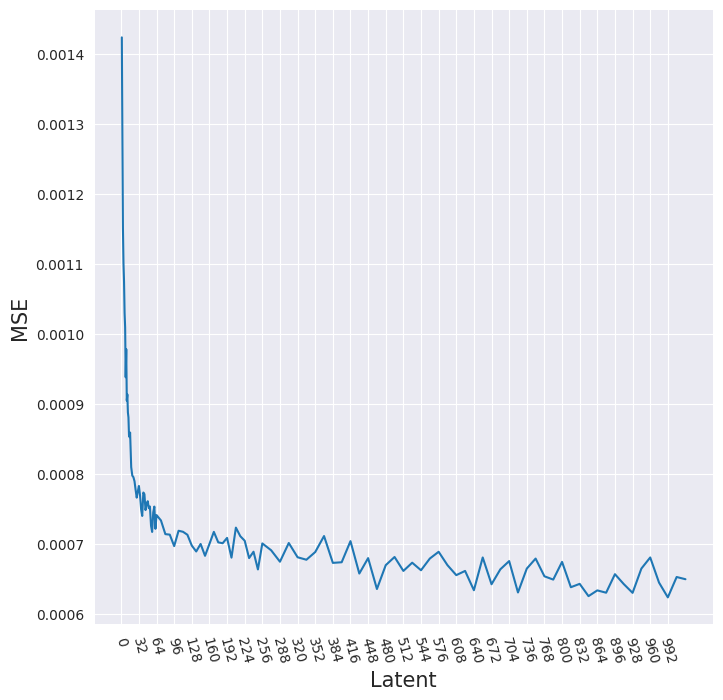

In [44]:
fig, axes = plt.subplots(1, figsize=(8,8)) 
lineplot = sns.lineplot(collected_data, x="Latent", y="MSE", ax=axes)
lineplot.set(xticks=range(0,1024,32))
lineplot.set_xticklabels(axes.get_xticklabels(), rotation=-75)

plt.show()